In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q omegaconf

In [3]:
import os
import math
import warnings
from typing import Dict, List, Optional, Tuple, Union

import glob
import regex

import tqdm.notebook as tqdm

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import librosa
import torchaudio

from omegaconf import OmegaConf

import matplotlib_inline
import matplotlib.pyplot as plt

from IPython.display import display, Audio, Markdown

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Для получения полного балла необходимо преодолеть порог по качеству: $\text{SNR}_{\text{model}} \ge 11dB$ на всех $4$ выборках. 

## `Задача денойзинга. Введение`

**Задача денойзинга** заключается в удалении посторонних звуков из входного аудио без ухудшения целевого сигнала. Стоит отметить, что выбор целевого и постороннего сигнала может разниться от задачи к задаче, например, можно рассматривать как удаление фонового шума для восстановления человеческой речи, так и наоборот, удаление речи из концертной записи. 

В данном задании Вам предлагается научиться отделять человеческую речь от различного шума.

Хотя существуют [методы](https://arxiv.org/pdf/2111.08678.pdf) для unsupervised решения этой задачи, более простым и интуитивным подходом является **supervised обучение**. Используя выборку "чистых" аудио $\mathcal{A} = \{a_{i}\}_{1}^{m}$ и набор шумов $\mathcal{N} = \{n_{j}\}_{1}^{k}$, можно создать синтетический датасет из пар *`чистое аудио`*/*`зашумлённое аудио`*.

В качестве функции потерь логично использовать метрику схожести между исходным аудио и аудио, восстановленным из зашумлённого сигнала. Такой метрикой может служить как расстояние между спектрограммами, так и расстояние между Waveforms.

В данной работе предлагается использовать $L_{1}$ расстояние между Waveforms:
$$
\mathfrak{L} = \mathbb{E}\mathcal{L}(a_{i}, \text{Denoiser}_{\theta}(a_{i} + \gamma n_{j})) = \mathbb{E}||a_{i} - \text{Denoiser}_{\theta}(a_{i} + \gamma n_{j})||_{1} \rightarrow \min_{\theta}\\ i \sim U\{1, ..., m\}, j \sim U\{1, ..., k\}, \gamma \sim U[\gamma_{min}, \gamma_{max}]
$$

Где $\gamma$ задаёт мощность шума относительно сигнала.

В качестве модели для восстановления сигнала $\text{Denoiser}_{\theta}$ предлагается использовать архитектуру [Conformer](https://arxiv.org/pdf/2005.08100.pdf). 

Более подробно о том, как задавать лосс на спектрограммах можно посмотреть в статье [SE-Conformer: Time-Domain Speech Enhancement Using Conformer](https://www.isca-speech.org/archive/pdfs/interspeech_2021/kim21h_interspeech.pdf).

## `Рекомендуемые гиперпараметры`

In [4]:
# Никогда так не делайте:
# Использование `eval` для парсинга произвольных конфигов несёт серьёзную угрозу безопасности
OmegaConf.register_new_resolver('eval', eval, replace=True)
config = OmegaConf.create({
    # Частота дискретизации аудио 
    'sample_rate': 16000,
    # Диапазон SNR в децибелах для зашумления
    'snr_range': (2, 5),

    # Параметры DataLoader
    'batch_size': 8,
    'num_workers': 8,

    # Параметры итоговой модели
    'n_fft': 1024,
    'hop_length': '${eval:${n_fft} // 4}',
    'win_length': '${n_fft}',
    'window': 'hann_window',
    'n_layers': 6,
    'd_model': '${eval:${n_fft} // 2}',
    'd_ff': '${eval:4 * ${d_model} // 2}',
    'n_heads': 4,
    'kernel_size': 31,
    'xscale': True,
    'dropout': 0.1,
    'dropout_emb': '${dropout}',
    'dropout_att': '${dropout}',
    
    # Параметры оптимизации
    'base_lr': 0.2,
    'min_lr': 1e-5,
    'max_norm': 0.01,
})
# print(OmegaConf.to_yaml(config, resolve=True))

# `Часть 0. Загрузка и предобработка данных (1 балл)`

Скачаем [чистые данные](https://openslr.elda.org/12/) и [аудио с шумом](https://openslr.elda.org/17/). Для обучения будем использовать аудиокниги на английском языке. Также, загрузим [русскоязычные аудио](https://openslr.elda.org/96/) для тестирования на out-of-domain данных.

In [ ]:
! wget https://www.openslr.org/resources/17/musan.tar.gz

In [8]:
! wget https://www.openslr.org/resources/17/musan.tar.gz

In [ ]:
! wget https://www.openslr.org/resources/12/train-clean-100.tar.gz

In [ ]:
! wget https://www.openslr.org/resources/96/ruls_data.tar.gz

In [ ]:
! tar xf musan.tar.gz

In [9]:
! tar xf musan.tar.gz

In [ ]:
! tar xf train-clean-100.tar.gz

In [ ]:
! tar -xf ruls_data.tar.gz -C ruls_data

In [5]:
noise_files_template = '/kaggle/input/musan-data-3/musan/noise/*/*.wav'
audio_files_template = '/kaggle/input/train-clean-100/LibriSpeech/train-clean-100/*/*/*.flac'
ru_audio_files_template = '/kaggle/input/ruls-data/dev/audio/*/*/*.wav'

Посмотрим на несколько сэмплов:

In [6]:
def display_audio(
    audiofile_path: Union[str, torch.Tensor], title: str = 'Пример аудио сигнала', sample_rate: Optional[int] = 16000
) -> None:
    '''
    :param Union[str, torch.Tensor] audiofile_path: Path to the audiofile or one-dimensional signal 
    :param str title: Plot title
    :param Optional[int] sample_rate: Signal sample rate
    '''
    if isinstance(audiofile_path, str):
        signal, sample_rate = torchaudio.load(audiofile_path)
        signal = torch.mean(signal, dim=0)
    else:
        signal, sample_rate = audiofile_path, sample_rate
    signal = signal.cpu().numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    ax.plot(np.arange(signal.shape[0]) / sample_rate, signal)

    ax.grid(True)

    ax.set_xlabel('Время')
    ax.set_ylabel('Магнитуда')

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()
    
    display(Audio(data=signal, rate=sample_rate, embed=True))
    
def mprint(*strings: List[str]) -> None:
    '''
    Display list of strings as a Markdown
    :param List[str] strings: List of texts
    '''
    for string in strings:
        display(Markdown(string))

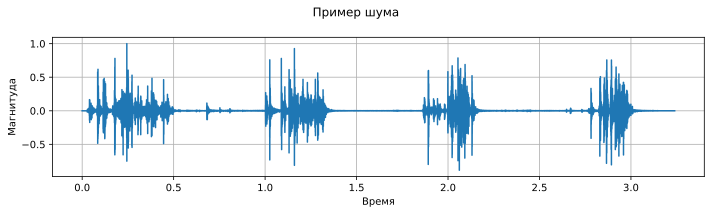

In [7]:
display_audio(glob.glob(noise_files_template)[0], 'Пример шума')
# display_audio(glob.glob(audio_files_template)[0], 'Пример "чистого" аудио')

Для работы с данными реализуем класс-датасет для аудио.

**Tips:** `glob.glob`, `torchaudio.functional.resample`

In [7]:
class AudioDataset(Dataset):
    def __init__(self, template: str, sample_rate: int):
        '''
        :param str template: Audio files template
        :param int sample_rate: Desired sample rate
        '''
        super().__init__()
        
        self.sample_rate = sample_rate
        self.paths = glob.glob(template)

        self.paths = sorted(self.paths)
        
    def __len__(self) -> int:
        '''
        Number of audio files
        :rtype: int
        '''
        return len(self.paths)
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        '''
        :param int idx: Audio file Id
        :return: One-dimensional signal with desired sample rate
        :rtype: torch.Tensor
        '''
        audio, orig_freq = torchaudio.load(self.paths[idx])
        audio_resampled = torchaudio.functional.resample(
            waveform=audio, orig_freq=orig_freq,
            new_freq=self.sample_rate
        )

        return audio_resampled

In [9]:
audio_ds = AudioDataset(audio_files_template, config.sample_rate)
noise_ds = AudioDataset(noise_files_template, config.sample_rate)
ru_clean_ds = AudioDataset(ru_audio_files_template, config.sample_rate)

In [10]:
mprint(
    f'Число "чистых" аудио: ${len(audio_ds)}$', 
    f'Число шумов: ${len(noise_ds)}$', 
    f'Число русскоязычных аудио: ${len(ru_clean_ds)}$'
)

Число "чистых" аудио: $28539$

Число шумов: $930$

Число русскоязычных аудио: $1400$

Для создания синтетического датасета реализуем набор вспомогательных функций:
1. `calc_energy(signal)` — подсчёт энергии сигнала в децибелах $E_{dB} = 10 \log_{10}E = 10 \log_{10}\Bigg(\sum\limits_{n} f^{2}(n)\Bigg)$
2. `calc_snr(signal, noise)` — отношение сигнал-шум в децибелах $\text{SNR}_{dB} = 10\log_{10} \frac{E_{\text{signal}}}{E_{\text{noise}}}$
3. `calc_coefficient(signal, noise, snr)` — находит коэффициент $\gamma$ такой, что $\text{SNR}_{dB}$ для `signal`, и $\gamma \times $`noise` равен `snr`

In [11]:
def calc_energy(signal: torch.Tensor) -> torch.Tensor:
    '''
    :param torch.Tensor signal: (..., time) tensor of signals. Assume that padding value is always zero
    :return: (...) signal energy in decibels
    :rtype: torch.Tensor
    '''
    if len(signal.size()) == 1:
        signal = signal.unsqueeze(0)

    return 10 * torch.log10(torch.sum(signal ** 2, dim=1))

In [84]:
def calc_snr(signal: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
    '''
    :param torch.Tensor signal: (..., time) batch of audio signals. Assume that padding value is always zero
    :param torch.Tensor noise: (..., time) batch of noise signals. Assume that padding value is always zero
    :return: SNR in decibels
    :rtype: torch.Tensor
    '''
    if len(signal.size()) == 1:
        signal = signal.unsqueeze(0)
    if len(noise.size()) == 1:
        noise = noise.unsqueeze(0)

    signal_energy = torch.sum(signal ** 2, dim=1)
    noise_energy = torch.sum(noise ** 2, dim=1)
    noise_energy_ratio = 10 * torch.log10(signal_energy / noise_energy)

    return noise_energy_ratio

In [85]:
def calc_coefficient(signal: torch.Tensor, noise: torch.Tensor, snr: torch.Tensor) -> torch.Tensor:
    '''
    :param torch.Tensor signal: (..., time) batch of audio signals. Assume that padding value is always zero
    :param torch.Tensor noise: (..., time) batch of noise signals. Assume that padding value is always zero
    :param torch.Tensor snr: (...) target SNRs in decibels after adding noise with desired coefficient
    :return: (...) coefficients for adding noise
    :rtype: torch.Tensor
    '''
    base = torch.tensor(10)

    if len(signal.size()) == 1:
        signal = signal.unsqueeze(0)
    if len(noise.size()) == 1:
        noise = noise.unsqueeze(0)

    signal_energy = torch.sum(signal ** 2, dim=1)
    noise_energy = torch.sum(noise ** 2, dim=1)

    coef = torch.sqrt(signal_energy / (noise_energy * torch.pow(base, snr/base)))
    
    return coef

In [86]:
signal = torch.tensor(np.random.default_rng(0).normal(size=(3, 100007)), dtype=torch.float32)
noise = torch.tensor(np.random.default_rng(1).normal(size=(3, 100007)), dtype=torch.float32)

# Check calc_energy
signal_E, noise_E = calc_energy(signal), calc_energy(noise[0])

assert tuple(signal_E.shape) == (3, )
npt.assert_almost_equal(noise_E.item(), 49.970214, decimal=5)
npt.assert_array_almost_equal(signal_E.numpy(), [50.001457, 50.020187, 50.008255], decimal=5)

# Check calc_snr
snr, snr_zero = calc_snr(signal, noise), calc_snr(signal[0], signal[0])

assert tuple(snr.shape) == (3, )
npt.assert_almost_equal(snr_zero.item(), 0.0, decimal=5)
npt.assert_array_almost_equal(snr.numpy(), [0.031242, 0.010986, 0.022178], decimal=5)

# Check calc_coefficient
coeffs_scalar = calc_coefficient(signal[0], noise[0], snr=10.0)
coeffs = calc_coefficient(signal, noise, snr=torch.tensor([1.0, 2.0, 3.0]))

assert tuple(coeffs.shape) == (3, )
npt.assert_almost_equal(coeffs_scalar.item(), 0.317367, decimal=5)
npt.assert_array_almost_equal(coeffs.numpy(), [0.894462, 0.795334, 0.709756], decimal=5)

# Check all together
npt.assert_array_almost_equal(calc_snr(signal, coeffs[:, None] * noise), torch.tensor([1.0, 2.0, 3.0]), decimal=5)

Реализуем трансформацию, которая будет зашумлять аудио $a_{i}$ случайным сигналом $n_{j}$ со случайной степенью зашумления $\gamma$. Коэффициент $\gamma$ выбирается из расчёта, что $\text{SNR}_{dB}$ $a_{i}$ и $\gamma \times n_{j}$ равен случайному $\text{SNR}_{dB}$ из заданного диапазона.

* Если шум длиннее аудио, то из аудио берётся случайный сегмент соответствующей длины
* Если аудио длиннее шума, то из шума берётся случайный сегмент соответствующей длины

In [15]:
class AddNoise:
    def __init__(self, noise_ds: AudioDataset, snr_range: Tuple[float, float]):
        '''
        :param AudioDataset noise_ds: Noise dataset
        :param Tuple[float, float] snr_range: SNR range in decibels specifying the noise power 
        '''
        self.noise_ds = noise_ds
        self.snr_range = snr_range
        
    def __call__(self, audio: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        '''
        :param torch.Tensor audio: One-dimensional audio signal
        :returns: Audio, added noise and noisy audio
        :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        '''
        # Sample noise idx and target SNR
        sampled_index = torch.randint(0, len(self.noise_ds), size=(1,)).item()
        low_snr, high_snr = self.snr_range[0], self.snr_range[1]
        sampled_snr = (torch.rand(1) * (high_snr - low_snr) + low_snr)[0]

        # If audio and noise lengths differ sample appropriate segments
        #   to match their lengths
        sampled_noise = self.noise_ds[sampled_index]
        #sampled_noise = sampled_noise.to(torch.float64)
        #audio = audio.to(torch.float64)
        noise_size = sampled_noise.size()[1]
        audio_size = audio.size()[1]

        if noise_size > audio_size:
            start_index = torch.randint(
                0, noise_size-audio_size+1, size=(1,)
            ).item()
            start, end = start_index, start_index + audio_size
            sampled_noise = sampled_noise[:, start: end]

        elif noise_size < audio_size:
            start_index = torch.randint(
                0, audio_size-noise_size+1, size=(1,)
            ).item()
            start, end = start_index, start_index + noise_size
            audio = audio[:, start: end]
            
        # Calculate multiplicative coefficient for noise and add noise to the audio
        coef = calc_coefficient(audio, sampled_noise, sampled_snr)

        return audio, coef * sampled_noise, audio + coef * sampled_noise

In [16]:
noise_transform = AddNoise(noise_ds, config.snr_range)

In [17]:
audio, noise, noised_audio = AddNoise(noise_ds, (100.0, 100.0))(audio_ds[0])
assert tuple(audio.shape) == tuple(noise.shape) == tuple(noised_audio.shape)
npt.assert_array_almost_equal(audio.numpy(), noised_audio.numpy(), decimal=5)

audio, noise, noised_audio = noise_transform(audio_ds[0])
npt.assert_array_almost_equal((audio + noise).numpy(), noised_audio.numpy())

In [ ]:
display_audio(noise, 'Шум')
display_audio(audio, 'Исходное аудио')
display_audio(noised_audio, 'Зашумлённое аудио')

Теперь, для создания синтетического датасета реализуем класс обёртку для зашумления аудио:

In [18]:
class NoiseAudioDataset(Dataset):
    def __init__(self, audio_ds: AudioDataset, noise_ds: AudioDataset, snr_range: Tuple[float, float]):
        '''
        :param AudioDataset audio_ds: Audio dataset
        :param AudioDataset noise_ds: Noise dataset
        :param Tuple[float, float] snr_range: SNR range in decibels specifying the noise power 
        '''
        super().__init__()
        
        self.audio_ds = audio_ds
        self.add_noise = AddNoise(noise_ds, snr_range)
        
    def __len__(self) -> int:
        '''
        Number of audio files
        :rtype: int
        '''
        return len(self.audio_ds)
        
    def __getitem__(self, idx: int) -> torch.Tensor:
        '''
        :param int idx: Audio file Id
        :return: Audio, added noise and noisy audio
        :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        '''
        audio = self.audio_ds[idx]
        audio, noise, noised_audio = self.add_noise(audio)

        audio = audio.squeeze(0)
        noise = noise.squeeze(0)
        noised_audio = noised_audio.squeeze(0)

        return audio, noise, noised_audio

Разобьём все аудио и все шумы на обучающие $\mathcal{A}_{\text{train}}, \mathcal{A}_{\text{test}}$ и тестовые выборки $\mathcal{N}_{\text{train}}, \mathcal{N}_{\text{test}}$ в соотношении $70$ на $30$.

Зададим:
* **Обучающую выборку**: $\mathcal{D}_{\text{train}} = \mathcal{A}_{\text{train}} \times \mathcal{N}_{\text{train}}$
* **Тестовую выборку с in-domain шумом**: $\mathcal{D}_{\text{test, in}} = \mathcal{A}_{\text{test}} \times \mathcal{N}_{\text{train}}$
* **Тестовую выборку с out-domain шумом**: $\mathcal{D}_{\text{test, out}} = \mathcal{A}_{\text{test}} \times \mathcal{N}_{\text{test}}$
* **Тестовую выборку с out-domain аудио и шумом** из русскоязычных записей и $\mathcal{N}_{\text{test}}$

**Tips:** `torch.utils.data.random_split`, `torch.Generator.manual_seed`

In [19]:
# Make train-test split 
split_sizes = [0.7, 0.3]
seed = 42
generator = torch.Generator()
generator.manual_seed(seed)

audio_ds_train, audio_ds_test = torch.utils.data.random_split(
    audio_ds, lengths=split_sizes, generator=generator
)
noise_ds_train, noise_ds_test = torch.utils.data.random_split(
    noise_ds, lengths=split_sizes, generator=generator
)

mprint(
    'Размер {0}: ${1}$, размер {2}: ${3}$'.format(
        r'$\mathcal{A}_{\text{train}}$', len(audio_ds_train),
        r'$\mathcal{A}_{\text{test}}$', len(audio_ds_test),
))
mprint(
    'Размер {0}: ${1}$, размер {2}: ${3}$'.format(
        r'$\mathcal{N}_{\text{train}}$', len(noise_ds_train),
        r'$\mathcal{N}_{\text{test}}$', len(noise_ds_test),
))

# Create datasets 
ru_ds = NoiseAudioDataset(ru_clean_ds, noise_ds_test, config.snr_range)
train_ds = NoiseAudioDataset(audio_ds_train, noise_ds_train, config.snr_range)
test_in_ds = NoiseAudioDataset(audio_ds_test, noise_ds_train, config.snr_range)
test_out_ds = NoiseAudioDataset(audio_ds_test, noise_ds_test, config.snr_range)

Размер $\mathcal{A}_{\text{train}}$: $19978$, размер $\mathcal{A}_{\text{test}}$: $8561$

Размер $\mathcal{N}_{\text{train}}$: $651$, размер $\mathcal{N}_{\text{test}}$: $279$

Так как аудио и шумы имеют разную длину, то для корректной работы `DataLoader` необходимо реализовать кастомный коллатор, который будет объединять последовательности разной длины в батчи, добавляя паддинг.

**Tips:** `torch.nn.utils.rnn.pad_sequence`

In [20]:
def collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    '''
    :param List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]] batch: List of samples from NoiseAudioDataset
    :return: Dictionary of tensors: {
            'length': torch.Tensor,        # (batch) signal lengths without padding
            'audio': torch.Tensor,         # (batch, time) batch of audio
            'noise': torch.Tensor,         # (batch, time) batch of noise
            'noisy_audio': torch.Tensor    # (batch, time) batch of noisy audio
        }
    :rtype: Dict[str, torch.Tensor]
    '''
    audios, noises, noised_audios = zip(*batch)

    lengths = torch.tensor(list(map(lambda x: x.size()[0], audios)))
    audios_pad = torch.nn.utils.rnn.pad_sequence(audios, batch_first=True)
    noises_pad = torch.nn.utils.rnn.pad_sequence(noises, batch_first=True)
    noised_audios_pad = torch.nn.utils.rnn.pad_sequence(noised_audios, batch_first=True)
    
    return {
        'length': lengths,
        'audio': audios_pad,
        'noise': noises_pad,
        'noisy_audio': noised_audios_pad
    }

In [21]:
# Create dataloaders 
ru_dl = DataLoader(ru_ds, collate_fn=collate_fn, batch_size=config.batch_size)
train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=config.batch_size)
test_in_dl = DataLoader(test_in_ds, collate_fn=collate_fn, batch_size=config.batch_size)
test_out_dl = DataLoader(test_out_ds, collate_fn=collate_fn, batch_size=config.batch_size)

print(f'Батчей в обучающей выборке: {len(train_dl)}')
print(f'Батчей в in-domain тестовой выборке: {len(test_in_dl)}')
print(f'Батчей в out-domain тестовой выборке: {len(test_in_dl)}')
print(f'Батчей в ru-out-domain тестовой выборке: {len(ru_dl)}')

Батчей в обучающей выборке: 2498
Батчей в in-domain тестовой выборке: 1071
Батчей в out-domain тестовой выборке: 1071
Батчей в ru-out-domain тестовой выборке: 175


In [22]:
batch = next(iter(train_dl))
batch

{'length': tensor([118320,  16704,  90880,   3632, 131440, 181280,  18893, 167120]),
 'audio': tensor([[-1.0681e-03, -1.1292e-03, -1.1597e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 8.4747e-02,  6.9092e-02,  4.1809e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-2.6550e-03, -7.9041e-03, -4.3945e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [-5.1880e-04, -7.3242e-04, -6.1035e-04,  ..., -1.8005e-03,
          -2.1362e-03, -1.8311e-03],
         [-4.2725e-04,  3.6621e-04,  9.7656e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  3.0518e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 'noise': tensor([[ 3.0869e-02,  1.6013e-02, -9.1404e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 3.9410e-05,  0.0000e+00, -3.9410e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-8.8895e-04,  6.8381e-05,  1.58

# `Часть 1. Реализация модели`

In [23]:
def hide_specs(module: torch.nn.Module) -> str:
    '''Remove hyperparameters for model __repr__
    :param torch.nn.Module module: Target model
    :return: Cleaned up repr
    :rtype: str
    '''
    module_repr = str(module)
    
    for spec in regex.findall("\(.*\): (.*)", module_repr):
        module_repr = module_repr.replace(spec, regex.sub('\(.*\)', '(...)', spec))
        
    return module_repr

Решение задачи базируется на предпосылке, что отделить шум от естественной речи значительно легче, используя спектральное представление звука. Другая причина — переход к STFT (Short-Time-Fourier-Transform) позволяет существенно уменьшить временную размерность, что особенно важно для моделей с механизмом внимания.

Заметим, что дальнейший переход от STFT к спектрограммам — это необратимая операция (как минимум теряется информация о фазе, что существенно для синтеза речи). Как следствие, использование модели для предсказания отчищенной спектрограммы и дальнейшего восстановления waveform из неё приведёт к сильным изменениям в исходном сигнале. Данную проблему можно решить, используя [вокодеры](https://analyticsindiamag.com/neural-vocoder-and-its-application-in-speech-recognition/)), однако, можно предложить более простой подход: будем предсказывать маску, которая будет использоваться для модификации исходного STFT. Затем, так как STFT обратимая операция, можно использовать ISTFT (Inverse Short-Time-Fourier-Transform) для восстановления аудио из спектрального представления.

Итого, предлагается реализовать следующий подход с использованием архитектуры Conformer:
1. Преобразование входного сигнала в спектральное представление с помощью STFT
2. Преобразование STFT в Power Spectrogram
3. Применение LayerNorm и линейного слоя
4. Применение набора Conformer блоков
5. Выход Conformer преобразуется с помощью линейного слоя и сигмоиды для предсказания маски
6. Произведение маски и STFT используется для восстановления аудио с помощью ISTFT

Обратите внимание, что STFT — компле́ксное представление сигнала. Как следствие, в графе вычислений модели возникнут операции с комплексными числами. Более того, функция потерь, как функция от выхода STFT не является аналитической, поэтому "обычная" комплексная производная будет не определена. Чтобы обойти эту проблему Pytorch использует **Производные Виртингера**. Более подробную информацию можно найти по ссылкам:
* [Документация Pytorch](https://pytorch.org/docs/stable/notes/autograd.html#autograd-for-complex-numbers)
* [The Complex Gradient Operator and the CR-Calculus](https://arxiv.org/pdf/0906.4835.pdf)
* [Вики](https://en.wikipedia.org/wiki/Wirtinger_derivatives)

С пользовательской точки зрения при использовании вещественных параметров, входов модели и лосса использование промежуточных комплексных операций не будет влиять на результаты вычислений производных и на процесс оптимизации.

## `Conformer Feed Forward Module (0.5 балла)`

Модель Conformer описывается следующим набором уравнений:

$$
\begin{equation}
\begin{split}
    \tilde{x_{i}}&= x_{i} + \frac{1}{2}\mathrm{FFN}(x_{i})   \\
    x'_{i}&= \tilde{x_{i}} + \mathrm{MHSA}(\tilde{x_{i}})    \\
    x''_{i}&= x'_{i} + \mathrm{Conv}(x'_{i})    \\
    y_{i}&= \mathrm{Layernorm}(x''_{i} + \frac{1}{2}\mathrm{FFN}(x''_{i}))    \\
\end{split} 
\label{model:conformer:equation}\tag{1}
\end{equation}
$$

Сначала реализуем полносвязный модуль Conformer.

**Feed Forward Module** определяется следующей последовательностью блоков:

Обратите внимание, что есть несогласованность между диаграммой и уравнением $(1)$. 

Для определённости будем считать, что Residual Connection **не входит** в Feed Forward Module, а является частью Conformer Block.

Реализуйте функцию активации [**Swish**](https://arxiv.org/pdf/1710.05941.pdf). Считайте, что $\beta=1$.

In [24]:
class Swish(torch.nn.Module):
    
    def __init__(self, beta=1.0) -> None:

        super(Swish, self).__init__()
        self.beta = beta

    
    def forward(
        self, x: torch.tensor
    ) -> torch.tensor:
        
        return x * torch.sigmoid(self.beta * x)


    def __repr__(self):
        return 'Swish()'

In [25]:
x = torch.tensor(np.random.default_rng(2).normal(size=(3, 5, 7)), dtype=torch.float32)
activation = Swish()
output = activation(x)

print(hide_specs(activation))
assert tuple(output.shape) == (3, 5, 7)
npt.assert_array_almost_equal(
    output.mean(dim=(0, 2)).numpy(), 
    [0.213066, 0.169422, 0.246992, 0.176728, 0.122522],
    decimal=5
)

Swish()


Реализуйте Feed Forward Module:

In [26]:
class ConformerFeedForward(torch.nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        '''
        :param int d_model: Input dimension
        :param int d_ff: Hidden dimension
        :param float dropout: Dropout probability for linear layers
        '''
        super().__init__()

        self.d_model = d_model
        self.d_ff = d_ff

        self.layer_norm = torch.nn.LayerNorm(d_model)
        self.linear_1 = torch.nn.Linear(d_model, d_ff, bias=True)
        self.activation = Swish()
        self.dropout_1 = torch.nn.Dropout1d(p=dropout)
        self.linear_2 = torch.nn.Linear(d_ff, d_model, bias=True)
        self.dropout_2 = torch.nn.Dropout1d(p=dropout)
        
        self.reset_parameters()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        :param torch.Tensor x: (batch, time, d_model)
        :return: (batch, time, d_model)
        :rtype: torch.Tensor
        '''
        x = self.layer_norm(x)
        x = self.linear_1(x)
        x = self.activation(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.dropout_2(x)
        
        return x
    
    def reset_parameters(self):
        ff_1_max = self.d_model ** -0.5
        ff_2_max = self.d_ff ** -0.5
        with torch.no_grad():
            torch.nn.init.uniform_(self.linear_1.weight, -ff_1_max, ff_1_max)
            torch.nn.init.uniform_(self.linear_2.weight, -ff_2_max, ff_2_max)
            
            torch.nn.init.uniform_(self.linear_1.bias, -ff_1_max, ff_1_max)
            torch.nn.init.uniform_(self.linear_2.bias, -ff_2_max, ff_2_max)

In [27]:
x = torch.tensor(np.random.default_rng(3).normal(size=(3, 5, 7)), dtype=torch.float32)
feed_forward = ConformerFeedForward(d_model=7, d_ff=7 * 4, dropout=0.1)
output = feed_forward(x)

print(hide_specs(feed_forward))
assert tuple(output.shape) == (3, 5, 7)
assert sum(_.numel() for _ in feed_forward.parameters()) == 441

ConformerFeedForward(
  (layer_norm): LayerNorm(...)
  (linear_1): Linear(...)
  (activation): Swish(...)
  (dropout_1): Dropout1d(...)
  (linear_2): Linear(...)
  (dropout_2): Dropout1d(...)
)


## `Conformer Convolution Module (1 балл)`

Convolution Module определяется следующей последовательностью блоков:

Для определённости будем считать, что Residual Connection **не входит** в Convolution Module, а является частью Conformer Block.

Информацию о том, что такое **Pointwise/Depthwise свёртки** можно посмотреть по [ссылке](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728).

Также, при обработке звука часто используют [Depthwise Casual свёртки](https://arxiv.org/pdf/1609.03499v2.pdf), чтобы не "заглядывать" в будущее. Однако, в данной задаче сигнал обрабатывается сразу для всех временных отсчётов и нет необходимости запрещать модели использовать правые контексты для каждого момента времени.

**Tips:** `torch.nn.Conv1d`. Обратите внимание, что `torch.nn.Conv1d` принимает на вход тензор размера $(B, C_{in}, L)$.

[Источник иллюстраций](https://arxiv.org/pdf/1809.01536.pdf):

| Тип  | Схема  |
|-----------------------|---|
| **Standart Convolution**  |   |
| **Pointwise Convolution** |   |
| **Depthwise Convolution** |   |

In [28]:
class ConformerConvolution(torch.nn.Module):
    def __init__(self, d_model: int, kernel_size: int, dropout: float):
        '''
        :param int d_model: Input dimension
        :param int kernel_size: Kernel size of Depthwise Convolution
        :param float dropout: Dropout probability 
        '''
        super().__init__()
        
        self.d_model = d_model
        self.kernel_size = kernel_size

        self.layer_norm = torch.nn.LayerNorm(d_model)
        self.pointwise_conv_1 = torch.nn.Conv1d(
            d_model, 2*d_model, kernel_size=1
        )
        self.activation_1 = torch.nn.GLU()
        self.depthwise_conv = torch.nn.Conv1d(
            d_model, d_model, kernel_size=kernel_size, 
            groups=d_model, padding='same'
        )
        self.batch_norm = torch.nn.BatchNorm1d(d_model)
        self.activation_2 = Swish()
        self.pointwise_conv_2 = torch.nn.Conv1d(
            d_model, d_model, kernel_size=1
        )
        self.dropout = torch.nn.Dropout1d(p=dropout)
        
        self.reset_parameters()

    def forward(self, x: torch.Tensor, pad_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        '''
        :param torch.Tensor x: (batch, time, d_model)
        :param torch.Tensor pad_mask: (batch, time) takes True value for the positions corresponding to the padding
        :return: (batch, time, d_model)
        :rtype: torch.Tensor
        '''
        # Apply layer norm
        x = self.layer_norm(x)
        # Apply the first pointwise convolution which expands number of channels
        x = self.pointwise_conv_1(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        # Apply GLU
        x = self.activation_1(x)

        if pad_mask is not None:
            # Fill elements correspond to padding with zeros
            x[pad_mask] = 0

        # Apply depthwise convolution
        x = self.depthwise_conv(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        # Apply BatchNorm
        x = self.batch_norm(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        # Apply activation
        x = self.activation_2(x)
        # Apply the second pointwise convolution
        x = self.pointwise_conv_2(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        # Apply dropout
        x = self.dropout(x)

        return x
    
    def reset_parameters(self):
        pw_max = self.d_model ** -0.5
        dw_max = self.kernel_size ** -0.5
        with torch.no_grad():
            torch.nn.init.uniform_(self.pointwise_conv_1.weight, -pw_max, pw_max)
            torch.nn.init.uniform_(self.pointwise_conv_2.weight, -pw_max, pw_max)
            torch.nn.init.uniform_(self.depthwise_conv.weight, -dw_max, dw_max)
            
            torch.nn.init.uniform_(self.pointwise_conv_1.bias, -pw_max, pw_max)
            torch.nn.init.uniform_(self.pointwise_conv_2.bias, -pw_max, pw_max)
            torch.nn.init.uniform_(self.depthwise_conv.bias, -dw_max, dw_max)

In [29]:
x = torch.tensor(np.random.default_rng(4).normal(size=(3, 15, 7)), dtype=torch.float32)
convolution = ConformerConvolution(d_model=7, kernel_size=5, dropout=0.1)
output = convolution(x)

print(hide_specs(convolution))
assert tuple(output.shape) == (3, 15, 7)
assert sum(_.numel() for _ in convolution.parameters()) == 238

ConformerConvolution(
  (layer_norm): LayerNorm(...)
  (pointwise_conv_1): Conv1d(...)
  (activation_1): GLU(...)
  (depthwise_conv): Conv1d(...)
  (batch_norm): BatchNorm1d(...)
  (activation_2): Swish(...)
  (pointwise_conv_2): Conv1d(...)
  (dropout): Dropout1d(...)
)


## `Multi-Headed Self-Attention Module (3 балла)`

**Multi-Headed Self-Attention Module** определяется следующей последовательностью блоков:

Для определённости будем считать, что LayerNorm, Dropout и Residual Connection **не входят** в Multi-Headed Self-Attention Module, а является частью Conformer Block.

В отличии от стандартного MHSA Conformer использует **Relative Positional Embedding** для передачи информации о позициях элементов в последовательности. 

Для реализации этого слоя необходимо внимательно изучить статью [Transformer-XL](https://arxiv.org/abs/1901.02860), а именно **Секцию 3.3** для информации об общей структуре Relative Attention и **Appendix B** для его эффективной реализации. 

Дополнительные материалы, которые помогут реализовать этот слой:
* https://jaketae.github.io/study/relative-positional-encoding/
* https://medium.com/@_init_/how-self-attention-with-relative-position-representations-works-28173b8c245a

Вкратце, Relative Positional Embedding использует следующую идею:

Рассмотрим "обычный" механизм внимания с позиционными эмбеддингами. 

Допустим, $E_{x_{i}}$ — эмбеддинг токена в позиции $i$, $U_{i}$ — позиционный эмбеддинг для позиции $i$, а матрицы $W_{q}, W_{k}, W_{v}$ — проекторы эмбеддингов в запросы, ключи и значения (смещения при вычислении запросов, ключей и значений опущены для краткости). 

Тогда механизм внимания можно записать следующим образом:
$$
Attention = \text{Softmax}(\frac{QK^{T}}{\sqrt{d_{k}}})V = \text{Softmax}(\frac{A}{\sqrt{d_{k}}})V
$$
Учитывая позиционные эмбеддинги, можно записать ненормированную вероятность между запросом $i$ и ключом $j$ :
$$
\begin{equation}
\begin{split}
A_{ij} = A^{\text{abs}}_{ij} &= (QK^{T})_{ij} = \Bigg[W_{q}(E_{x_{i}} + U_{i})\Bigg]^{T}\Bigg[W_{k}(E_{x_{j}} + U_{j})\Bigg] = \\
&= 
\underbrace{E_{x_{i}}^{T}W_{q}^{T}W_{k}E_{x_{j}}}_{(a)} + \underbrace{E_{x_{i}}^{T}W_{q}^{T}W_{k}U_{j}}_{(b)} +\\ &+ \underbrace{U_{i}^{T}W_{q}^{T}W_{k}E_{x_{j}}}_{(c)} + \underbrace{U_{i}^{T}W_{q}^{T}W_{k}U_{j}}_{(d)}
\end{split}
\end{equation}
$$

Теперь, можно заменить абсолютные позиционные эмбеддинги $U_{j}$ на относительные эмбеддинги $R_{i-j}$, которые зависят от разницы в позициях токенов $i$ и $j$. С другой стороны, абсолютные позиционные эмбеддинги $U_{i}$ для токенов запроса предлагается заменить на обучаемые параметры $u, v$, гарантируя, что позиция токена-запроса не будет влиять на вероятности внимания.

Наконец, заменяя проектор для позиционных эмбеддингов на $W_{k,R}$, получим:
$$
\begin{equation}
\begin{split}
A^{\text{rel}}_{ij} &= \\
&= 
\underbrace{E_{x_{i}}^{T}W_{q}^{T}W_{k}E_{x_{j}}}_{(a)} + \underbrace{E_{x_{i}}^{T}W_{q}^{T}W_{k,R}R_{i-j}}_{(b)} +\\ &+ \underbrace{u^{T}W_{k}E_{x_{j}}}_{(c)} + \underbrace{v^{T}W_{k,R}R_{i-j}}_{(d)} = \\
&= \underbrace{(W_{q}E_{x_{i}} + u)^{T}W_{k}E_{x_{j}}}_{(ac)} + \underbrace{(W_{q}E_{x_{i}} + v)^{T}W_{k,R}R_{i-j}}_{(bd)}
\end{split} 
\end{equation}
$$

Вычисление значений $(ac)$ не представляет труда и аналогично "обычному" механизму внимания. 

Обратите внимание, что для вычисления матрицы из значений $(bd)$ нужно сконструировать тензор $\{R_{i-j}\}_{i,j} \in \mathbb{R}^{L \times L \times d}$ — квадратичный размер по длине последовательности $L$ с большим коэффициентом $d$ (размерность скрытого пространства). 

Однако, учитывая, что $R_{i - j}$ может принимать только $2L - 1$ различных значений, можно понизить сложность вычисления матрицы $(bd)$ до линейной по длине входной последовательности. Для этого конструируется матрица $R \in \mathbb{R}^{(2L - 1) \times d}$ из всех возможных значений $R_{i - j}$, вычисляется матричное произведение $W_{k,R}R$, а затем выполняется операция $\text{RelativeShift}$, описанная в **Appendix B** статьи [Transformer-XL](https://arxiv.org/abs/1901.02860).

Итого, получим:
$$
\begin{equation}
\begin{split}
A^{\text{rel}} &= \\
&= \underbrace{(Q + u)K^{T}}_{(ac)} + \underbrace{\text{RelativeShift}\Bigg((Q + v)(W_{k}R)^{T}\Bigg)}_{(bd)}
\end{split} 
\end{equation}
$$

Следующая диаграмма показывает особенности операции RelativeShift и работы с позиционными эмбеддингами:

Реализуйте MultiHead Attention с относительными позиционными эмбеддингами:

In [182]:
class RelPositionMultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model: int, n_head: int, dropout: float):
        '''
        x:param int d_model: Input dimension
        x:param int kernel_size: Number of MHSA heads
        x:param float dropout: Dropout probability for attention probabilities
        '''
        super().__init__()

        assert d_model % n_head == 0
        
        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_model // n_head

        # Linear transformations for queries, keys and values (W_{q}, W_{k}, W_{v})
        self.linear_q = torch.nn.Linear(d_model, d_model, bias=True)
        self.linear_k = torch.nn.Linear(d_model, d_model, bias=True)
        self.linear_v = torch.nn.Linear(d_model, d_model, bias=True)
        
        # Linear transformation for positional encoding (W_{k,R}). Do not use bias
        self.linear_pos = torch.nn.Linear(d_model, d_model, bias=False)

        # These two learnable biases that are used in matrix c and matrix d
        # as described in https://arxiv.org/abs/1901.02860 Section 3.3
        self.pos_bias_u = torch.nn.Parameter(torch.zeros(n_head, self.d_k))
        self.pos_bias_v = torch.nn.Parameter(torch.zeros(n_head, self.d_k))
        
        # Dropout layer for attention probabilities
        self.dropout = torch.nn.Dropout(p=dropout)

        # Linear transformation for model output
        self.linear_out = torch.nn.Linear(d_model, d_model, bias=True)

        self.reset_parameters()
        
    @staticmethod
    def rel_shift(x: torch.Tensor) -> torch.Tensor:
        '''Compute relative positional encoding.
        :param torch.Tensor x: (batch, head, time_x, time_y)
        :return: (batch, head, time_x, time_y)
        :rtype: torch.Tensor
        '''
        batch, head, time_x, time_y = x.shape
        # Add a column of zeros on the left side of last dimension to perform the relative shifting
        zero_pad = torch.zeros(batch, head, time_x, 1, device=device)
        x = torch.cat((zero_pad, x), dim=-1)
        # Reshape matrix
        x = x.view(batch, head, -1, time_x)
        # Drop the first row and reshape matrix back
        x = x[:, :, 1:, :]
        x = x.view(batch, head, time_x, -1)

        return x

    def forward_qkv(
        self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Transform query, key and value.
        :param torch.Tensor query: (batch, time_1, d_model)
        :param torch.Tensor key:   (batch, time_2, d_model)
        :param torch.Tensor value: (batch, time_2, d_model)

        :return: (q, k, v):
            torch.Tensor q: (batch, head, time_1, d_k)
            torch.Tensor k: (batch, head, time_2, d_k)
            torch.Tensor v: (batch, head, time_2, d_k)
        :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        """
        # Apply linear transformations for queries, keys and values
        q, k, v = self.linear_q(query), self.linear_k(key), self.linear_v(value)
        q = q.view(query.size()[0], self.n_head, -1, self.d_k)
        k = k.view(key.size()[0], self.n_head, -1, self.d_k)
        v = v.view(value.size()[0], self.n_head, -1, self.d_k)

        return q, k, v

    def forward_attention(self, value: torch.Tensor, scores: torch.Tensor, mask: Optional[torch.Tensor]=None) -> torch.Tensor:
        """Compute attention context vector.
        :param torch.Tensor value:    (batch, head, time_2, d_k)
        :param torch.Tensor scores:   (batch, head, time_1, time_2)
        :param Optional[torch.Tensor] mask: (batch, time_1, time_2) attention mask between queries and keys
            Takes True value for the positions corresponding to which tokens should NOT be attended to

        :return: Transformed `value` of shape (batch, time_1, d_model) weighted by the attention scores
        :rtype: torch.Tensor
        """
        if mask is not None:
            # Mask scores so that the won't be used in attention probabilities
            scores.masked_fill_(mask.unsqueeze(1), float('-inf'))
            # Calculate attention probabilities
            # Do not forget to mask probabilities
            scores = torch.nn.functional.softmax(scores, dim=-1)
        else:
            # Calculate attention probabilities
            scores = torch.nn.functional.softmax(scores, dim=-1)

        # Apply attention dropout
        scores = self.dropout(scores)
        # Reweigh value w.r.t. attention probabilities
        threshold = 1e-4
        zero_scores = scores.abs() <= threshold
        scores.masked_fill_(zero_scores, float('-inf'))
        scores = torch.nn.functional.softmax(scores, dim=-1)

        x = torch.matmul(scores, value)
        x = x.view(x.size()[0], -1, self.n_head * self.d_k)
        # Apply output linear transformation
        x = self.linear_out(x)

        return x

    def forward(
        self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, 
        mask: Optional[torch.Tensor], pos_emb: torch.Tensor
    ) -> torch.Tensor:
        '''Compute 'Scaled Dot Product Attention' with rel. positional encoding.
        :param torch.Tensor query:          (batch, time_1, d_model)
        :param torch.Tensor key:            (batch, time_2, d_model)
        :param torch.Tensor value:          (batch, time_2, d_model)
        :param Optional[torch.Tensor] mask: (batch, time_1, time_2) attention mask between queries and keys
            Takes True value for the positions corresponding to which tokens should NOT be attended to
        :param torch.Tensor pos_emb:        (batch, 2*time_2-1, d_model) relative positional embeddings 
            for all possible values of i - j

        :return: Transformed `value` of shape (batch, time_1, d_model) weighted by the query-key attention
        :rtype: torch.Tensor
        '''
        # Apply linear transformation for positional embeddings
        rel_emb_proj = self.linear_pos(pos_emb).view(
            pos_emb.size()[0], self.n_head, -1, self.d_k
        )
        # Apply linear transformation for queries, keys and values
        q, k, v = self.forward_qkv(query, key, value)
        # Sum q with biases
        # I.e (W_{q}E_{x_{i}} + u) and (W_{q}E_{x_{i}} + v)
        q_u = q.transpose(1, 2) + self.pos_bias_u
        q_u = q_u.transpose(1, 2)
        q_v = q.transpose(1, 2) + self.pos_bias_u
        q_v = q_v.transpose(1, 2)
        # Compute attention scores
        # First compute matrix a + matrix c
        #   as described in https://arxiv.org/abs/1901.02860 Section 3.3
        # (batch, head, time1, time2)
        ac = torch.matmul(q_u, k.transpose(2, 3))
        # Compute matrix b + matrix d
        bd = torch.matmul(q_v, rel_emb_proj.transpose(2, 3))
        # Apply relative shift to b + d matrix
        bd = self.rel_shift(bd)
        # Drops extra elements in the matrix_bd to match the matrix_ac's size
        bd = bd[:, :, :, :v.size()[2]]

        scores = (ac + bd) / math.sqrt(self.d_k)  # (batch, head, time_1, time_2)
        
        # Compute reweighed values using scores and mask
        out = self.forward_attention(v, scores, mask)

        return out
    
    def reset_parameters(self):
        f_max = self.d_model ** -0.5
        with torch.no_grad():
            torch.nn.init.uniform_(self.linear_q.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_k.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_v.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_out.weight, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_pos.weight, -f_max, f_max)

            torch.nn.init.uniform_(self.linear_q.bias, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_k.bias, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_v.bias, -f_max, f_max)
            torch.nn.init.uniform_(self.linear_out.bias, -f_max, f_max)

In [31]:
x = (torch.arange(4)[:, None] + 10 * torch.arange(-3, 4)[None, :]).unsqueeze(0).unsqueeze(0)
rel_shift = RelPositionMultiHeadAttention.rel_shift(x).squeeze(0).squeeze(0)[:, :4]

assert tuple(rel_shift.shape) == (4, 4)
npt.assert_array_equal(
    rel_shift.numpy(),
    np.array([
        [  0,  10,  20,  30],
        [ -9,   1,  11,  21],
        [-18,  -8,   2,  12],
        [-27, -17,  -7,   3]
    ])
)

In [32]:
query = torch.tensor(
    np.random.default_rng(5).normal(size=(3, 15, 512)), dtype=torch.float32
)
key = torch.tensor(
    np.random.default_rng(6).normal(size=(3, 17, 512)), dtype=torch.float32
)
value = torch.tensor(
    np.random.default_rng(7).normal(size=(3, 17, 512)), dtype=torch.float32
)
mask = torch.tensor(
    np.random.default_rng(8).normal(size=(3, 15, 17)) > 0.0, dtype=torch.bool
)
pos_emb = torch.tensor(
    np.random.default_rng(9).normal(size=(3, 2 * 17 - 1, 512)), dtype=torch.float32
)

rmhsa = RelPositionMultiHeadAttention(d_model=512, n_head=4, dropout=0.1)
output = rmhsa(query, key, value, mask=mask, pos_emb=pos_emb)

print(hide_specs(rmhsa))
assert tuple(output.shape) == (3, 15, 512)
assert sum(_.numel() for _ in rmhsa.parameters()) == 1313792

RelPositionMultiHeadAttention(
  (linear_q): Linear(...)
  (linear_k): Linear(...)
  (linear_v): Linear(...)
  (linear_pos): Linear(...)
  (dropout): Dropout(...)
  (linear_out): Linear(...)
)


## `Relative Positional Encoding (1 балл)`

Также, нужно реализовать слой, который будет выполнять позиционное кодирование входных признаков.

Из диаграммы выше видно, что для последовательности длины $L$ для эффективного вычисления матрицы $(bd)$ нужно сформировать матрицу из относительных позиционных эмбеддингов:
$$
R = \begin{equation}
\left[
  \begin{array}{c}
  R_{L-1} \\
  ... \\
  R_{0} \\
  ... \\
  R_{-L+1} \\
  \end{array}
\right]
\end{equation}
$$

Так как $R$ динамически зависит от конкретного входного батча, также как в абсолютных позиционных эмбеддингах, необходимо создать буфер, в котором будут храниться эмбеддинги для всех возможных индексов:
$$
R = \begin{equation}
\left[
  \begin{array}{c}
  R_{L_{max}-1} \\
  ... \\
  R_{0} \\
  ... \\
  R_{-L_{max}+1} \\
  \end{array}
\right]
\end{equation}
$$

Обратите внимание, что в отличии от абсолютных позиционных эмбеддингов, чтобы взять эмбеддинги соответствующие конкретному батчу, их нужно брать из "середины" буфера, а не из его начала.

В данной задаче предлагается брать необучаемые эмбеддинги, которые инициализированы в соответствии со статьёй [Attention Is All You Need](https://arxiv.org/pdf/1706.03762):

$$
PE_{(\text{pos}, 2i)} = \sin(\text{pos} \big/ 10000^{2i \big/ d_{\text{model}}})  \\
PE_{(\text{pos}, 2i+1)} = \cos(\text{pos} \big/ 10000^{2i \big/ d_{\text{model}}})
$$

In [185]:
class RelPositionalEncoding(torch.nn.Module):
    '''Relative positional encoding for TransformerXL's layers
    See : Appendix B in https://arxiv.org/abs/1901.02860
    '''

    def __init__(self, d_model, dropout, max_len=5000, xscale=False, dropout_emb=0.0):
        '''Construct an RelPositionalEncoding object.
        :param int d_model: Embedding dim
        :param float dropout: Dropout probability for input embeddings
        :param int max_len: Maximum input length
        :param bool xscale: Whether to scale the input by sqrt(d_model)
        :param float dropout_emb: Dropout probability for positional embeddings
        '''
        super().__init__()

        self.d_model = d_model
        self.xscale = xscale

        # Create Dropout layer for input embeddings
        self.dropout = torch.nn.Dropout(p=dropout)
        
        # Create Dropout layer for positional embeddings
        self.dropout_emb = torch.nn.Dropout(p=dropout_emb)
        
        # Positions must be from positive numbers to negative
        # Positive positions will be used for left positions and negative for right positions
        positions = torch.arange(-max_len + 1, max_len)
        self.create_pe(positions)

    def create_pe(self, positions: torch.Tensor):
        '''Compute positional encoding for given indices
        :attr torch.Tensor pe: (1, pos_length, d_model)
        :param torch.Tensor positions: (pos_length)
        '''
        pos_length = positions.size(0)
        base = 10000
        pe = torch.zeros(pos_length, self.d_model)

        # Compute positional encoding
        # as described in https://arxiv.org/abs/1706.03762 Section 3.5
        indexes = torch.arange(0, self.d_model)
        indexes[1::2] = indexes[1::2] - 1
        indexes = indexes.unsqueeze(0)
        positions = torch.flip(positions, dims=[0])
        positions = positions.repeat(self.d_model, 1).transpose(0, 1)
        exp = positions * (1 / (base ** (indexes / self.d_model)))
        
        pe[:, 0::2] = torch.sin(exp[:, 0::2])
        pe[:, 1::2] = torch.cos(exp[:, 1::2])
        pe = pe.unsqueeze(0)

        # Save precomputed positional embeddings
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''Compute positional encoding.
        :param torch.Tensor x: Input of size(batch, time, feature_size)

        :return Tuple[torch.Tensor, torch.Tensor]: (x, pos_emb):
            torch.Tensor x: (batch, time, feature_size)
            torch.Tensor pos_emb: (1, 2*time-1, feature_size)
        '''
        # Rescale input
        if self.xscale:
            x = x / math.sqrt(self.d_model)
        # Apply embeddings dropout
        x = self.dropout(x)
        # Center_pos would be the index of position 0
        # Negative positions would be used for right and positive for left tokens
        # for input of length L, 2*L-1 positions are needed, positions from (L-1) to -(L-1)
        center = self.pe.size()[1] // 2
        right, left = center - x.size()[1] + 1, center + x.size()[1]
        pos_embs = self.pe[:, right:left, :]
        # Apply positional embeddings dropout
        pos_embs = self.dropout_emb(pos_embs)

        return x, pos_embs

In [34]:
encoding = RelPositionalEncoding(d_model=6, dropout=0.1, max_len=7)
print(hide_specs(encoding))

assert tuple(encoding.pe.shape) == (1, 7 * 2 - 1, 6)
npt.assert_array_almost_equal(
    encoding.pe.sum(dim=(0, 1)).numpy(),
    np.array([
        1.19209290e-07, 4.48703647e-01, -2.98023224e-08, 
        1.28048248e+01, 0.00000000e+00,  1.29995775e+01
    ])
)

x = torch.tensor(np.random.default_rng(10).normal(size=(3, 5, 6)), dtype=torch.float32)
output, pos_emb = encoding(x)

assert tuple(output.shape) == (3, 5, 6)
assert tuple(pos_emb.shape) == (1, 2 * 5 - 1 , 6)
npt.assert_array_almost_equal(pos_emb.numpy(), encoding.pe[:, 2:11].numpy())

RelPositionalEncoding(
  (dropout): Dropout(...)
  (dropout_emb): Dropout(...)
)


## `Conformer Block (0.5 балла)`

Теперь необходимо собрать `ConformerFeedForward`, `ConformerConvolution` и `RelPositionMultiHeadAttention` в один блок:

In [35]:
class ConformerBlock(torch.nn.Module):
    def __init__(self, d_model: int, d_ff: int, n_heads: int, kernel_size: int, dropout: float, dropout_att: float):
        """
        :param int d_model: Input dimension
        :param int d_ff: Hidden dimension for Feed Forward Module
        :param int n_heads: Number of MHSA heads
        :param int kernel_size: Kernel size of Depthwise Convolution
        :param float dropout: Dropout probability for Feed Forward and Convolution Modules
        :param float dropout_att: Dropout probability for attention probabilities
        """
        super().__init__()

        self.fc_factor = 0.5

        self.feed_forward_1 = ConformerFeedForward(
            d_model=d_model, d_ff=d_ff, dropout=dropout
        )

        self.layer_norm_attn = torch.nn.LayerNorm(d_model)
        self.self_attn = RelPositionMultiHeadAttention(
            d_model=d_model, n_head=n_heads, dropout=dropout_att
        )
        self.dropout_attn = torch.nn.Dropout(p=dropout_att)

        self.conv = ConformerConvolution(
            d_model=d_model, kernel_size=kernel_size, dropout=dropout
        )

        self.feed_forward_2 = ConformerFeedForward(
            d_model=d_model, d_ff=d_ff, dropout=dropout
        )

        self.layer_norm_out = torch.nn.LayerNorm(d_model)

    def forward(
        self, x: torch.Tensor, pos_emb: torch.Tensor, 
        att_mask: Optional[torch.Tensor] = None, pad_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        :param torch.Tensor x: (batch, time, d_model) input features 
        :param torch.Tensor pos_emb: (batch, 2*time-1, d_model) relative positional embeddings 
            for all possible values of i - j
        :param Optional[torch.Tensor] att_mask: (batch, time, time) attention mask between queries and keys
            Takes True value for the positions corresponding to which tokens should NOT be attended to
        :param Optional[torch.Tensor] pad_mask: (batch, time) padding mask
            Takes True value for the positions corresponding to the padding
        :return: (batch, time, d_model)
        :rtype: torch.Tensor
        """
        
        # Apply first Feed Forward Block with residual connection
        # Do not forget about fc_factor
        x_residual = self.fc_factor * x
        x = self.feed_forward_1(x) + x_residual
        x = self.layer_norm_attn(x)
        
        # Apply MHSA Block with residual connection
        x_residual = x
        x = self.self_attn(x, x, x, att_mask, pos_emb) + x_residual
        x = self.dropout_attn(x)

        # Apply Convolutional Block with residual connection
        x_residual = x
        x = self.conv(x, pad_mask) + x_residual
        
        # Apply second Feed Forward Block with residual connection
        x_residual = self.fc_factor * x
        x = self.feed_forward_2(x) + x_residual
        x = self.layer_norm_out(x)

        return x

In [36]:
block = ConformerBlock(d_model=512, d_ff=4 * 512, n_heads=4, kernel_size=31, dropout=0.1, dropout_att=0.1)
encoding = RelPositionalEncoding(d_model=512, dropout=0.1, max_len=5000)

print(hide_specs(block))

assert sum(_.numel() for _ in block.parameters()) == 6323712

x = torch.tensor(np.random.default_rng(11).normal(size=(7, 127, 512)), dtype=torch.float32)
output = block(*encoding(x))
assert tuple(output.shape) == (7, 127, 512)

ConformerBlock(
  (feed_forward_1): ConformerFeedForward(
    (layer_norm): LayerNorm(...)
    (linear_1): Linear(...)
    (activation): Swish(...)
    (dropout_1): Dropout1d(...)
    (linear_2): Linear(...)
    (dropout_2): Dropout1d(...)
  )
  (layer_norm_attn): LayerNorm(...)
  (self_attn): RelPositionMultiHeadAttention(
    (linear_q): Linear(...)
    (linear_k): Linear(...)
    (linear_v): Linear(...)
    (linear_pos): Linear(...)
    (dropout): Dropout(...)
    (linear_out): Linear(...)
  )
  (dropout_attn): Dropout(...)
  (conv): ConformerConvolution(
    (layer_norm): LayerNorm(...)
    (pointwise_conv_1): Conv1d(...)
    (activation_1): GLU(...)
    (depthwise_conv): Conv1d(...)
    (batch_norm): BatchNorm1d(...)
    (activation_2): Swish(...)
    (pointwise_conv_2): Conv1d(...)
    (dropout): Dropout1d(...)
  )
  (feed_forward_2): ConformerFeedForward(
    (layer_norm): LayerNorm(...)
    (linear_1): Linear(...)
    (activation): Swish(...)
    (dropout_1): Dropout1d(...)
   

## `Finally, Conformer (0 баллов)`

Теперь мы можем полностью собрать модель `Conformer`:

In [145]:
class Conformer(torch.nn.Module):
    def __init__(
        self, n_layers: int, d_model: int, d_ff: int, n_heads: int,  kernel_size: int, 
        max_len: int, xscale: bool, dropout_emb: float, dropout: float, dropout_att: float
    ):
        '''
        :param int n_layers: Number of Conformer Blocks
        :param int d_model: Input dimension
        :param int d_ff: Hidden dimension for Feed Forward Module
        :param int n_heads: Number of MHSA heads
        :param int kernel_size: Kernel size of Depthwise Convolution
        :param int max_len: Maximum input length
        :param bool xscale: Whether to scale the input by sqrt(d_model)
        :param float dropout_emb: Dropout probability for positional embeddings
        :param float dropout: Dropout probability for Feed Forward and Convolution Modules
        :param float dropout_att: Dropout probability for attention probabilities
        '''
        super().__init__()

        self.encoding = RelPositionalEncoding(
            d_model=d_model, dropout=dropout,
            dropout_emb=dropout_emb, xscale=xscale,
            max_len=max_len
        )

        blocks = list()
        for i in range(n_layers):
            block = ConformerBlock(
                d_model=d_model, d_ff=d_ff, n_heads=n_heads, 
                kernel_size=kernel_size, dropout=dropout,
                dropout_att=dropout_att
            )
            blocks.append(block)

        self.layers = torch.nn.ModuleList(blocks)
        
    @staticmethod
    def _create_masks(max_length, length: torch.Tensor) -> Tuple[torch.BoolTensor, torch.BoolTensor]:
        
        '''
        :param int max_length: Maximum size of time dimension in the batch
        :param torch.Tensor length: (batch) length of sequences in batch
        :return: (pad_mask, att_mask):
            torch.BoolTensor pad_mask: (batch, max_length)
                Takes True value for the positions corresponding to the padding
            torch.BoolTensor att_mask: (1, max_length, max_length)
                Takes True value for the positions corresponding to which tokens should NOT be attended to
            Where max_length is a size of time dimension of the batch
        :rtype: Tuple[torch.BoolTensor, torch.BoolTensor]
        '''
        # pad_mask is the masking to be used to ignore paddings
        bs = len(length)
        length = length.to('cpu')
        pad_mask = torch.arange(max_length).repeat(bs, 1) < length[:, None]
        pad_mask = ~pad_mask

        # att_mask is the masking to be used in self-attention
        att_mask = torch.full((len(length), max_length, max_length), False)
        for idx, ln in enumerate(length):
            att_mask[idx, :, ln:]  = True
            att_mask[idx, ln:, :] = True

        return pad_mask, att_mask
    
    def forward(self, x: torch.Tensor, length: torch.Tensor) -> torch.Tensor:
        '''
        :param torch.Tensor x: (batch, time, d_model) input features
        :param torch.Tensor length: (batch) length of sequences in batch
        :return:
        :rtype: torch.Tensor
        '''
        # Create masks
        pad_mask, att_mask = self._create_masks(x.size()[1], length)
        pad_mask, att_mask = pad_mask.to(device), att_mask.to(device)
        
        # Encode input features
        x, pos_embs = self.encoding(x)
        
        # Apply Conformer Blocks
        for layer in self.layers:
            x = layer(x, pos_embs, att_mask, pad_mask)

        return x

In [ ]:
conformer = Conformer(
    n_layers=4, d_model=512, d_ff=4 * 512, n_heads=4, kernel_size=31,
    max_len=5000, xscale=True, dropout_emb=0.1, dropout=0.1, dropout_att=0.1
)
print(hide_specs(conformer))

assert sum(_.numel() for _ in conformer.parameters()) == 25294848

x = torch.tensor(np.random.default_rng(12).normal(size=(7, 127, 512)), dtype=torch.float32)
length = torch.tensor(np.random.default_rng(13).choice(127, 7), dtype=torch.long)
output = conformer(x, length)

assert tuple(output.shape) == (7, 127, 512)

## `Denoising Conformer (0.5 балла)`

Теперь осталось вспомнить, что мы работаем со звуком и прежде чем подавать сигнал на вход модели его нужно предобработать в соответствии со списком действий в начале этой секции. 

Реализуйте итоговый пайплайн для задачи денойзинга в классе `DenoisingConformer`:

In [178]:
class DenoisingConformer(torch.nn.Module):
    window_fns = {
        'bartlett_window': torch.bartlett_window,
        'blackman_window': torch.blackman_window,
        'hamming_window': torch.hamming_window,
        'hann_window': torch.hann_window,
        'kaiser_window': torch.kaiser_window
    }
    
    def __init__(
        self, n_fft: int, hop_length: int, win_length: int, window: str,
        
        n_layers: int, d_model: int, d_ff: int, n_heads: int,  kernel_size: int, 
        max_len: int, xscale: bool, dropout_emb: float, dropout: float, dropout_att: float
    ):
        '''
        :param int n_fft: Length of the windowed signal after padding with zeros. 
            The number of rows in the STFT matrix is (1 + n_fft/2)
        :param int hop_length: Number of audio samples between adjacent STFT columns.
        :param int win_length: Each frame of audio is windowed by window of length win_length 
            and then padded with zeros to match n_fft.
        :param str window: A window specification
            
        :param int n_layers: Number of Conformer Blocks
        :param int d_model: Input dimension
        :param int d_ff: Hidden dimension for Feed Forward Module
        :param int n_heads: Number of MHSA heads
        :param int kernel_size: Kernel size of Depthwise Convolution
        :param int max_len: Maximum input length
        :param bool xscale: Whether to scale the input by sqrt(d_model)
        :param float dropout_emb: Dropout probability for positional embeddings
        :param float dropout: Dropout probability for Feed Forward and Convolution Modules
        :param float dropout_att: Dropout probability for attention probabilities
        '''
        super().__init__()
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        
        # Calculate feature size after STFT transformation
        d_stft = 1 + n_fft // 2
        
        # Create buffer for window function values
        window = DenoisingConformer.window_fns[window](win_length)
        self.register_buffer('window', window)

        self.layer_norm = torch.nn.LayerNorm(d_stft)
        self.linear_in = torch.nn.Linear(d_stft, d_model, bias=True)
        
        self.encoder = Conformer(
            n_layers=n_layers, d_model=d_model, d_ff=d_ff, 
            n_heads=n_heads, kernel_size=kernel_size, max_len=max_len, 
            xscale=xscale, dropout_emb=dropout_emb, dropout=dropout,
            dropout_att=dropout_att
        )
        
        self.linear_out = torch.nn.Linear(d_model, d_stft, bias=True)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, noised_audio: torch.Tensor, length: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        '''
        :param torch.Tensor noised_audio: (batch, time) input audio signal
        :param torch.Tensor length: (batch) length of sequences in batch
        :return: Denoised audio, original STFT representation, predicted mask
        :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        '''
        
        # Apply STFT
        fourier_coefs = torch.stft(
            noised_audio, n_fft=self.n_fft, 
            hop_length=self.hop_length, onesided=True,
            window=self.window, return_complex=True
        ).transpose(1, 2)
                
        # Calculate Power Spectrogram from STFT
        specgram = torch.pow(torch.abs(fourier_coefs), 2)
        
        # Apply LayerNorm and Linear
        x = self.linear_in(self.layer_norm(specgram))
        
        # Calculate lengths of sequences after STFT
        # Note: they do not equal to the STFT shape!
        bs_length = (length - self.win_length) // self.hop_length + 1

        # Apply Conformer
        x = self.encoder(x, bs_length)
        
        # Predict mask for spectrum
        mask = self.sigmoid(self.linear_out(x))
        
        # Multiply mask and STFT and apply ISTFT to recover waveform
        denoised_audio = torch.istft(
            (mask * fourier_coefs).transpose(1, 2), n_fft=self.n_fft, 
            hop_length=self.hop_length, win_length=self.win_length, 
            window=self.window, # length=noised_audio.size()[1]
        )
        
        return denoised_audio, fourier_coefs, mask

In [173]:
model = DenoisingConformer(
    n_fft=config.n_fft, hop_length=config.hop_length, win_length=config.win_length, window=config.window,
    
    n_layers=config.n_layers, d_model=config.d_model, d_ff=config.d_ff, n_heads=config.n_heads, 
    kernel_size=config.kernel_size, max_len=5000, xscale=config.xscale, 
    dropout_emb=config.dropout_emb, dropout=config.dropout, dropout_att=config.dropout_att
)
print(hide_specs(model))

DenoisingConformer(
  (layer_norm): LayerNorm(...)
  (linear_in): Linear(...)
  (encoder): Conformer(
    (encoding): RelPositionalEncoding(
      (dropout): Dropout(...)
      (dropout_emb): Dropout(...)
    )
    (layers): ModuleList(
      (0-5): 6 x ConformerBlock(
        (feed_forward_1): ConformerFeedForward(
          (layer_norm): LayerNorm(...)
          (linear_1): Linear(...)
          (activation): Swish(...)
          (dropout_1): Dropout1d(...)
          (linear_2): Linear(...)
          (dropout_2): Dropout1d(...)
        )
        (layer_norm_attn): LayerNorm(...)
        (self_attn): RelPositionMultiHeadAttention(
          (linear_q): Linear(...)
          (linear_k): Linear(...)
          (linear_v): Linear(...)
          (linear_pos): Linear(...)
          (dropout): Dropout(...)
          (linear_out): Linear(...)
        )
        (dropout_attn): Dropout(...)
        (conv): ConformerConvolution(
          (layer_norm): LayerNorm(...)
          (pointwise_conv_1)

# `Часть 2. Обучение модели`

## `Noam Scheduler (0.5 балла)`

При обучении моделей с механизмом внимания желательно использовать расписание темпа обучения с Warmup. 

Реализуйте scheduler из статьи [Attention Is All You Need, Section 5.3](https://arxiv.org/abs/1706.03762):

In [174]:
class NoamAnnealing(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self, optimizer: torch.optim.Optimizer, *, 
        d_model: int, warmup_steps: int, min_lr: float = 0.0, last_epoch: int = -1
    ):
        """
        :param torch.optim.Optimizer optimizer:
        :param int d_model: Model input dimension
        :param int warmup_steps:
        :param float min_lr: Lower bound for learning rate after warmup
        :param int last_epoch:
        """
        assert warmup_steps
        
        # It is necessary to assign all attributes *before* __init__,
        # as class is wrapped by an inner class.
        self.min_lr = min_lr
        self.warmup_steps = warmup_steps
        self.normalization = d_model ** (-0.5)

        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn(
                "To get the last learning rate computed by the scheduler, please use `get_last_lr()`.", UserWarning
            )

        step = max(1, self.last_epoch)
        new_lrs = [
            self._noam_annealing(initial_lr=initial_lr, step=step) 
            for initial_lr in self.base_lrs
        ]
        return new_lrs

    def _noam_annealing(self, initial_lr: float, step: int) -> float:
        """Compute noam annealing learning rate 
            as described in https://arxiv.org/abs/1706.03762 Section 5.3.
            After warmup_steps learning rate should be always greater than min_lr

        :param float initial_lr: Additional multiplicative factor for learning rate
        :param int step: Current optimization step
        :return: Learning rate at given step
        :rtype: float
        """
        lr = self.normalization * min(step ** (-0.5), step * (self.warmup_steps ** (-1.5)))
        lr *= initial_lr
        
        if step > self.warmup_steps:
            lr = max(lr, self.min_lr)
        
        return lr

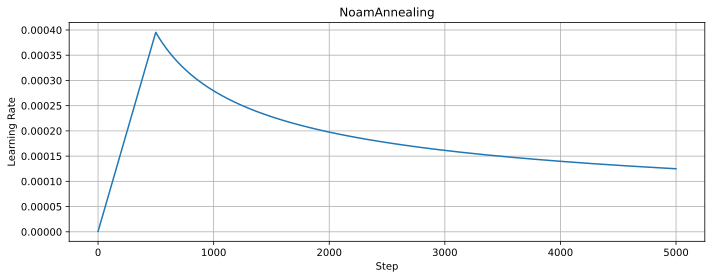

In [175]:
%%capture --no-stdout --no-display
scheduler = NoamAnnealing(
    torch.optim.Adam(model.parameters(), lr=0.2),
    d_model=512, warmup_steps=500, min_lr=1e-5
)

learning_rates = []
for _ in range(5000):
    scheduler.step()
    learning_rates.append(scheduler.get_last_lr()[0])
    
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(learning_rates)
ax.grid(True)
ax.set_xlabel('Step')
ax.set_ylabel('Learning Rate')
ax.set_title('NoamAnnealing')

fig.tight_layout()
plt.show()

## `Цикл обучения (1 балл)`

Создадим функцию потерь, оптимизатор и scheduler. Выберем число warmup шагов равным $20\%$ от числа шагов в одной эпохе:

In [165]:
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
else:
    device = torch.device('cpu')

In [166]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.base_lr)
scheduler = NoamAnnealing(
    optimizer, d_model=config.d_model, 
    warmup_steps=len(train_dl) // 5, min_lr=config.min_lr
)

writer = SummaryWriter(log_dir='./denoising_logs')

### `Mixed Precision`

Для ускорения обучения можно использовать Mixed Precision, который позволяет автоматически выполнять некоторые операции (в основном матричные умножения) с пониженной точностью. 

Изучите [туториал по Mixed Precision](https://pytorch.org/docs/stable/notes/amp_examples.html#typical-mixed-precision-training) и примените его для ускорения обучения. 

### `Gradient Clipping`

Для повышения стабильности обучения желательно не допускать шагов градиентного спуска для батчей с аномально большими значениями градиента. Есть два популярных подхода:
* [`torch.nn.utils.clip_grad_norm_`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) — если норма градиента превосходит заданное значение, градиент ренормируется, чтобы его норма уменьшилась до указанной величины
* [`torch.nn.utils.clip_grad_value_`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_value_.html) — обрезает значения градиентов, выходящие за заданный диапазон

Используйте `torch.nn.utils.clip_grad_norm_` в данном задании.

Обратите внимание, что при использовании Mixed Precision обычно используется Gradient Scaling. Так как Clipping должен выполняться для исходных градиентов необходимо предварительно сделать [обратное масштабирование](https://pytorch.org/docs/stable/notes/amp_examples.html#gradient-clipping).

### `Метрики качества`

Для оценки качества работы модели можно замерять SNR:
$$
\text{SNR}_{\text{input}} = \text{SNR}_{dB}(a_{i}, n_{j}) \\
\text{SNR}_{\text{model}} = \text{SNR}_{dB}(a_{i}, \text{Denoiser}_{\theta}(a_{i} + n_{j}) - a_{i})
$$

$\text{SNR}_{\text{input}}$ показывает насколько сильно сигнал был зашумлён изначально, а $\text{SNR}_{\text{model}}$ насколько сильно остался зашумлён сигнал после денойзинга.

Также, введём величину $\text{SNR}_{\text{delta}} = \text{SNR}_{\text{model}} - \text{SNR}_{\text{input}}$ для оценки величины снижения зашумления.

В процессе обучения и на валидации считайте средние значения $\text{SNR}_{\text{input}}, \text{SNR}_{\text{model}}, \text{SNR}_{\text{delta}}$.

Корректная реализация модели и обучения должна выдавать $\text{SNR}_{\text{model}} \approx 11dB$ уже после одной эпохи обучения.

### `Сигналы нулевой энергии`

В выборке аудио сигналов встречаются записи с длительными промежутками тишины, длиннее некоторых шумов. Как следствие, при генерации данных для зашумления может быть засемплирован участок аудио без какого-либо сигнала. Обучение модели на таких сигналах не представляет проблем, однако метрики качества $\text{SNR}_{\text{input}}$, $\text{SNR}_{\text{model}}$ в этом случае равны $-\infty$. 

При подсчёте метрик качества не учитывайте элементы батча для которых или $\text{SNR}_{\text{input}}$, или $\text{SNR}_{\text{model}}$ не определены. Не убирайте эти сигналы из подсчёта лосса.

**Tips:** `torch.isinf`, `torch.isnan`

### `Evaluation`

In [167]:
def evaluate(
    model: DenoisingConformer, dataloader: DataLoader, loss_fn: torch.nn.Module, device: torch.device
) -> Dict[str, float]:
    '''Compute metrics over the dataset
    :param DenoisingConformer model:
    :param DataLoader dataloader:
    :param torch.nn.Module loss_fn: Callable for loss computation. Assume that mean reduction is used
    :param torch.device device:
    :return: Evaluated metrics
    :rtype: Dict[str, float]
    '''
    model.to(device)
    model.eval()
    
    n = 0
    n_non_zero = 0
    total_loss = 0.0
    total_input_snr = 0.0
    total_model_snr = 0.0
    total_delta_snr = 0.0
    with torch.no_grad():
        for batch in (pbar := tqdm.tqdm(dataloader, total=len(dataloader))):
            # Move tensors to device
            length = batch['length'].to(device)
            audio = batch['audio'].to(device)
            noised_auido = batch['noisy_audio'].to(device)
            noise = batch['noise'].to(device)
            
            # Perform forward pass
            denoised_audio, fourier_coefs, mask = model(noised_audio, length)
            total_loss += loss_fn(audio, denoised_audio).item()
            n += audio.size()[0]
            
            # Calculate SNRs
            snr_model = calc_snr(audio, denoised_audio - noise)
            snr_input = calc_snr(audio, noise)
            snr_delta = snr_model - snr_input
            
            # Update statistics
            # Do not forget to exclude inf/nan SNR values 
            snr_input = snr_input[~torch.isnan(snr_input)]
            snr_model = snr_model[~torch.isnan(snr_model)]
            snr_delta = snr_delta[~torch.isnan(snr_delta)]
            
            snr_input = snr_input[~torch.isinf(snr_input)]
            snr_model = snr_model[~torch.isinf(snr_model)]
            snr_delta = snr_delta[~torch.isinf(snr_delta)]
            
            total_input_snr += torch.sum(snr_input).item()
            total_model_snr += torch.sum(snr_model).item()
            total_delta_snr += torch.sum(snr_delta).item()
            
            n_non_zero += (len(snr_input) + len(snr_model) + len(snr_delta)) // 3
            
            pbar.set_description(
                'Loss: {0:.2e}, SNR Input/Model/Delta: {1:.3f}/{2:.3f}/{3:.3f}'.format(
                    total_loss / n, total_input_snr / n_non_zero, total_model_snr / n_non_zero, total_delta_snr / n_non_zero
                ) 
            )
            
    return {
        'Loss': total_loss / n,
        'SNR/input': total_input_snr / n_non_zero,
        'SNR/model': total_model_snr / n_non_zero,
        'SNR/delta': total_delta_snr / n_non_zero,
    }

### `Training`

In [192]:
def train(
    n_epochs: int, model: DenoisingConformer, train_dataloader: DataLoader, loss_fn: torch.nn.Module, 
    optimizer: torch.optim.Optimizer, max_norm: float = 0.010, scheduler: torch.optim.lr_scheduler._LRScheduler = None,
    test_dataloaders: Dict[str, DataLoader] = None, device: torch.device = torch.device('cpu'), writer: SummaryWriter = None
) -> List[Dict[str, Dict[str, float]]]:
    '''
    :param int n_epochs:
    :param DenoisingConformer model:
    :param DataLoader train_dataloader:
    :param torch.nn.Module loss_fn:
    :param torch.optim.Optimizer optimizer:
    :param float max_norm: Max norm of the gradients for Gradient Clipping
    :param torch.optim.lr_scheduler._LRScheduler scheduler:
    :param Dict[str, DataLoader] test_dataloaders: Dataloaders for evaluation
    :param torch.device device:
    :param SummaryWriter writer:
    :return: List of dictionaries with metrics for all dataloader in test_dataloaders and 
        with running metrics for train_dataloader after each epoch
    :rtype: List[Dict[str, Dict[str, float]]]
    '''
    model.to(device)
    results = []
    
    scaler = torch.cuda.amp.GradScaler()
    for epoch in tqdm.tqdm(range(n_epochs), total=n_epochs):
        model.train()
        epoch_results = {}
        
        n = 0
        n_non_zero = 0
        total_loss = 0.0
        total_input_snr = 0.0
        total_model_snr = 0.0
        total_delta_snr = 0.0
        for idx, batch in enumerate(pbar := tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            # Clear gradients
            optimizer.zero_grad()
            
            # Move tensors to device
            length = batch['length'].to(device)
            audio = batch['audio'].to(device)
            noised_audio = batch['noisy_audio'].to(device)
            noise = batch['noise'].to(device)

            # Perform forward pass
            with autocast(device_type='cuda', dtype=torch.float16):
                denoised_audio, fourier_coefs, mask = model(noised_audio, length)
                loss = loss_fn(audio, denoised_audio)
            
            # Perform backward pass
            scaler.scale(loss).backward()
            
            # Perform Gradient Clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), max_norm=max_norm
            )
            
            # Perform Optimization Step
            scaler.step(optimizer)
            scaler.update()
            
            # Perform Scheduler Step
            if scheduler is not None:
                scheduler.step()
            
            # Calculate SNRs and update statistics
            # Do not forget to exclude inf/nan SNR values
            snr_model = calc_snr(audio, denoised_audio - noise)
            snr_input = calc_snr(audio, noise)
            snr_delta = snr_model - snr_input

            snr_input = snr_input[~torch.isnan(snr_input)]
            snr_model = snr_model[~torch.isnan(snr_model)]
            snr_delta = snr_delta[~torch.isnan(snr_delta)]
            
            snr_input = snr_input[~torch.isinf(snr_input)]
            snr_model = snr_model[~torch.isinf(snr_model)]
            snr_delta = snr_delta[~torch.isinf(snr_delta)]
            
            total_input_snr += torch.sum(snr_input).item()
            total_model_snr += torch.sum(snr_model).item()
            total_delta_snr += torch.sum(snr_delta).item()
            
            n_non_zero += (len(snr_input) + len(snr_model) + len(snr_delta)) // 3

            total_loss += loss.item()
            n += audio.size()[0]
            
            if writer is not None:
                step = idx + epoch * len(train_dataloader)
                writer.add_scalar('Lr', current_lr, global_step=step)
                writer.add_scalar('GradNorm', grad_norm, global_step=step)
                writer.add_scalar('Loss/batch', loss.item(), global_step=step)
                writer.add_scalar('SNR/Input/batch', input_snr / (~mask).sum().item(), global_step=step)
                writer.add_scalar('SNR/Model/batch', model_snr / (~mask).sum().item(), global_step=step)
                writer.add_scalar('SNR/Delta/batch', (model_snr - input_snr) / (~mask).sum().item(), global_step=step)
            
            pbar.set_description(
                'Lr: {0:.2e}, GradNorm: {1:.2e}, Loss: {2:.2e}, SNR Input/Model/Delta: {3:.3f}/{4:.3f}/{5:.3f}'.format(
                    current_lr, grad_norm, total_loss / n, 
                    total_input_snr / n_non_zero, total_model_snr / n_non_zero, total_delta_snr / n_non_zero
                ) 
            )
        
        epoch_results['train'] = {
            'Loss': total_loss / n,
            'SNR/input': total_input_snr / n_non_zero,
            'SNR/model': total_model_snr / n_non_zero,
            'SNR/delta': total_delta_snr / n_non_zero,
        }
        
        if test_dataloaders is not None:
            for dataset_name, dataloader in test_dataloaders.items():
                epoch_results[dataset_name] = evaluate(model, dataloader, loss_fn, device)
        
        results.append(epoch_results)
        if writer is not None:
            for dataset_name, metrics in epoch_results.items():
                for metric_name, metric_value in metrics.items():
                    writer.add_scalar(f'{metric_name}/{dataset_name}', metric_value, global_step=epoch)
        
    return results

In [195]:
model = DenoisingConformer(
    n_fft=config.n_fft, hop_length=config.hop_length, win_length=config.win_length, window=config.window,
    
    n_layers=config.n_layers, d_model=config.d_model, d_ff=config.d_ff, n_heads=config.n_heads, 
    kernel_size=config.kernel_size, max_len=5000, xscale=config.xscale, 
    dropout_emb=config.dropout_emb, dropout=config.dropout, dropout_att=config.dropout_att
)

Обучите модель:

In [ ]:
results = train(
    5, model, train_dl, loss_fn, optimizer, max_norm=config.max_norm, scheduler=scheduler,
    test_dataloaders={'test_in_domain': test_in_dl, 'test_out_domain': test_out_dl, 'test_ru': ru_dl}, 
    device=device, writer=writer
)

## `Анализ модели (1 балл)`

Используя функцию ниже, продемонстрируйте результаты работы на нескольких примерах. 

Проанализируйте предсказания модели. Как предсказанные маски для спектра сигнала связаны со спектром шума?

Если ли разница между результатами на in-domain и out-domain шуме? А на in-domain и out-domain аудио? Поясните с примерами.

In [48]:
@torch.no_grad()
def plot_sample_info(
    audio: torch.Tensor, noise: torch.Tensor, noisy_audio: torch.Tensor, 
    model: DenoisingConformer, device: torch.device
):
    '''
    :param torch.Tensor audio: Audio
    :param torch.Tensor noise: Added noise
    :param torch.Tensor noisy_audio: Noisy audio
    :param DenoisingConformer model: 
    :param torch.device device:
    '''
    model.eval()
    
    length = torch.tensor(audio.shape[0], dtype=torch.long)
    audio, noise, noisy_audio, length = (
        audio.to(device), noise.to(device), noisy_audio.to(device), length.to(device)
    )
    
    denoised_audio, spectrum, mask = model(noisy_audio.unsqueeze(0), length.unsqueeze(0))
    denoised_audio, spectrum, mask = denoised_audio[0], spectrum[0], mask[0]
    
    original_spectrum = torch.stft(
        audio.unsqueeze(0), n_fft=model.n_fft, return_complex=True,
        hop_length=model.hop_length, win_length=model.win_length, window=model.window
    )[0]
    noise_spectrum = torch.stft(
        noise.unsqueeze(0), n_fft=model.n_fft, return_complex=True,
        hop_length=model.hop_length, win_length=model.win_length, window=model.window
    )[0]
    
    fig, axes = plt.subplots(2, 3, figsize=(10, 10))

    axes[0][0].imshow(original_spectrum.abs().log().cpu().numpy())
    axes[0][1].imshow(spectrum.abs().log().cpu().numpy())
    axes[0][2].imshow(mask.abs().cpu().numpy())
    axes[1][0].imshow((spectrum * mask).abs().log().cpu().numpy())
    axes[1][1].imshow(noise_spectrum.abs().log().cpu().numpy())

    axes[0][0].set_title('Audio')
    axes[0][1].set_title('Noisy audio')
    axes[0][2].set_title('Mask')
    axes[1][0].set_title('Denoised')
    axes[1][1].set_title('Noise')

    axes[0][0].set_axis_off()
    axes[0][1].set_axis_off()
    axes[0][2].set_axis_off()
    axes[1][0].set_axis_off()
    axes[1][1].set_axis_off()
    axes[1][2].set_axis_off()
    
    fig.tight_layout()
    plt.show()
    
    display_audio(noise, title='Шум')
    display_audio(audio, title='Исходное аудио')
    display_audio(noisy_audio, title='Зашумлённое аудио')
    display_audio(denoised_audio, title='Denoised аудио')

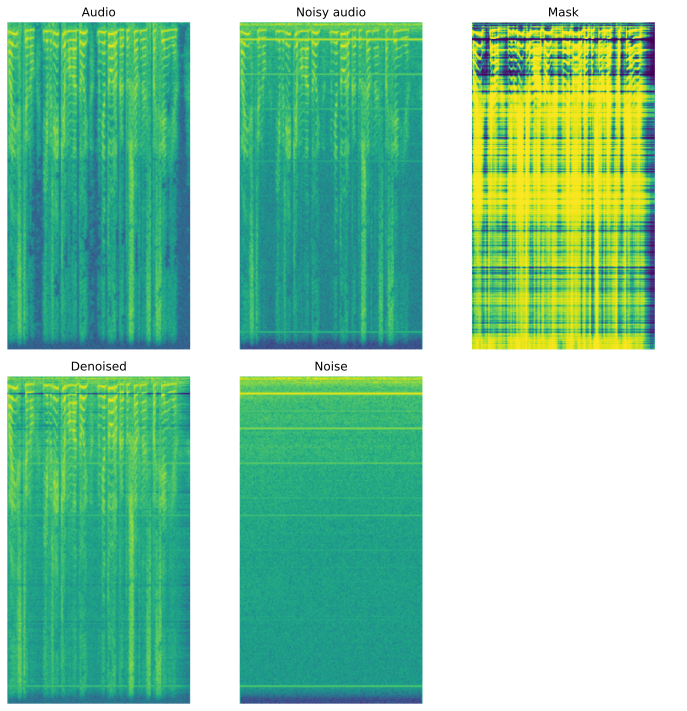

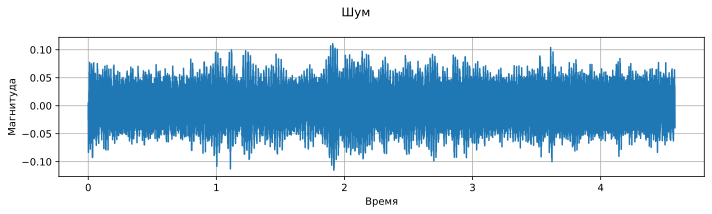

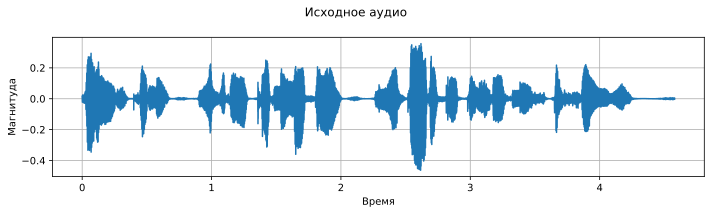

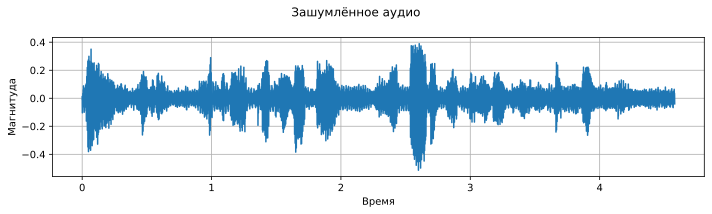

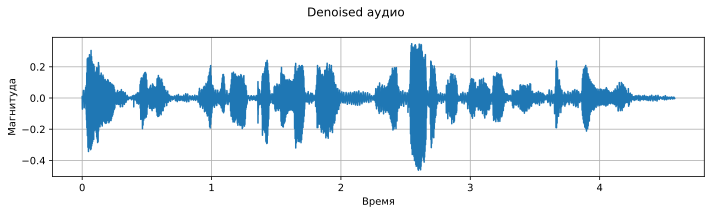

In [49]:
plot_sample_info(*ru_ds[0], model, device)

# `Бонус. Улучшение качества (до 5 баллов)`

Улучшите качество любым способом.

Например, можно:
* Дольше учить
* Использовать более сложную функцию потерь
* Подобрать более оптимальные гиперпараметры
* Использовать более сложную архитектуру модели

Баллы начисляются за прохождение порогов по $\text{SNR}_{\text{model}}$ на out-of-domain шуме:
* $\text{SNR}_{\text{model}} \ge 15 \Longrightarrow +1 \text{ балл}$
* $\text{SNR}_{\text{model}} \ge 16 \Longrightarrow +2 \text{ балла}$
* $\text{SNR}_{\text{model}} \ge 17 \Longrightarrow +3 \text{ балла}$
* $\text{SNR}_{\text{model}} \ge 18 \Longrightarrow +4 \text{ балла}$
* $\text{SNR}_{\text{model}} \ge 19 \Longrightarrow +5 \text{ баллов}$
* $\text{SNR}_{\text{model}} \ge 30 \Longrightarrow +100 \text{ баллов}$

# `Бонус. Метрики качества (до 3 баллов)`

Проверите анализ литературы и предложите альтернативную метрику оценки качества денойзинга. 

Приведите замеры качества с использованием этой метрики. Сравните её с $\text{SNR}_{\text{model}}$. 

Приведите примеры сэмплов где новая метрика лучше отражает качество денойзинга, а где проигрывает $\text{SNR}_{\text{model}}$.